# Anomaly detection with an Autoencoder
In this laboratory, you will train an autoencoder with a dataset of benign traffic to make it learn the profile of the normal behaviour of the network. The current script will test the trained autoencoder on the test set of benign traffic, so that you can understand the maximum error produced by the trained autoencoder in reconstructing the normal traffic. 

This operation gives you the idea of what threshold can be set to detect anomalies (all the traffic flows whose reconstruction error is higher than the treshold are classified as anomalies). Copy the last cell of this notebook to test the autoencoder on the DOS2019 dataset of DDoS attacks. Set a threshold and compute the accuracy of the system using the F1 score metric.  

| <img src="../Images/autoencoder.png" width="90%"> |
|:--:|
| Autoencoder|

In [ ]:
# Author: Roberto Doriguzzi-Corin
# Project: Lecture on Intrusion Detection with Deep Learning
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import sys
import time
import glob
import pprint
import argparse

import keras.callbacks
import tensorflow as tf
import numpy as np
import random as rn
import os
import csv
import h5py
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Seed Random Numbers
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=1)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,  Flatten, Conv2D, Reshape, Input, UpSampling2D
from tensorflow.keras.layers import  MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential, save_model, load_model, clone_model
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from scipy.stats import *
from numpy.random import randint
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
tf.random.set_seed(SEED)
K.set_image_data_format('channels_last')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

In [ ]:
def mean_squared_error(x_true,x_pred):
    mse = ((x_true-x_pred)**2).mean(axis=(1,2))

    return mse

In [ ]:
def load_dataset(path):
    filename = glob.glob(path)[0]
    dataset = h5py.File(filename, "r")
    set_x_orig = np.array(dataset["set_x"][:])  # features
    set_y_orig = np.array(dataset["set_y"][:])  # labels

    X = np.reshape(set_x_orig, (set_x_orig.shape[0], set_x_orig.shape[1], set_x_orig.shape[2], 1))
    Y = set_y_orig

    return X, Y

## Performance metrics
The following method computes the metrics to assess the performance of the models on the given datasets. Both accuracy and F1 Score are widely used metrics in many domains of the computer science. More information can be found in the ```sklearn``` documentation ([accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)) and in online documentation (e.g., [Metrics to Evaluate your Machine Learning Algorithm](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)). 

In [ ]:
def compute_metrics(Y_true, Y_pred):
    Y_true = Y_true.reshape((Y_true.shape[0], 1))
    accuracy = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    return accuracy, f1

## Autoencoder implementation
It's worth noting that you should use the same input and output shape for your autoencoder's input and output layer, otherwise you will receive a shape error.

In [ ]:
def AutoencoderMLP(input_shape=(10,11,1), learning_rate=0.01):
    model = Sequential(name="autoencoder-mlp")
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu', name='enc0'))
    model.add(Dense(32, activation='relu', name='enc1'))
    model.add(Dense(8, activation='relu', name='enc2'))
    model.add(Dense(8, activation='relu', name='dec0'))
    model.add(Dense(32, activation='relu', name='dec1'))
    model.add(Dense(256, activation='relu', name='dec2'))
    model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid', name='dec3'))
    model.add(Reshape(input_shape))

    compileModel(model, learning_rate)
    print(model.summary())
    return model

In [ ]:
def compileModel(model,lr):
    optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # here we specify the loss function

## Training phase
Here we train the autoencoder using a patience value of 10 epochs and a maximum numer of epochs set to 100. Note that, we do not need any labels in anomaly detection tasks, as the input and the expected output of an autoencoder are the same.

In [ ]:
X_train, _ = load_dataset("../Datasets/HTTP-Benign/*benign*" + '-train.hdf5')
X_val, _ = load_dataset("../Datasets/HTTP-Benign/*benign*" + '-val.hdf5')

autoencoder = AutoencoderMLP()
autoencoder.fit(X_train, X_train, batch_size=512, epochs=1000,validation_data=(X_val, X_val), callbacks=[EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=25)])

print("Saving best model's weights...")
autoencoder.save("./" + autoencoder.name + ".h5")

## Preliminary test phase
The the trained autoencoder on the test set of benign traffic to verify the maximum error computed on the normal data. You can use this information to set the threshold for anomaly detection.

Model:  ./autoencoder-mlp.h5
MSE loss on test data: [0.00872963 0.00872968 0.00874292 0.00872968 0.00931097 0.00872965
 0.00872965 0.00872973 0.00872963 0.00872972 0.00874274 0.00872963
 0.00872982 0.00874291 0.00872991 0.00872962 0.0087296  0.00872961
 0.00872983 0.0087296  0.00874291 0.00872963 0.00872962 0.0087431
 0.00872978 0.00872972 0.00874313 0.00872972 0.00872972 0.00874294
 0.00872965 0.00874304 0.00872966 0.0087296  0.0087296  0.00872961
 0.0087427  0.00872965 0.00874289 0.00874315 0.00872963 0.00872951
 0.00872961 0.00874308 0.00874306 0.00872982 0.0087428  0.00874302
 0.00874288 0.0087427  0.00874288 0.0087428  0.00872884 0.00872987
 0.00931118 0.00872962 0.00874275 0.02792269 0.00874271 0.00872987
 0.00872954 0.00874274 0.0087429  0.00872962 0.00872987 0.00872963
 0.00872982 0.00872973 0.00874295 0.00872981 0.00874304 0.00874273
 0.00872976 0.00872962 0.0087298  0.00872977 0.00874273 0.00872978
 0.00872962 0.00872959 0.00872978 0.00872977 0.00874294 0.00872885
 0.00874294

2023-02-03 14:23:24.214679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


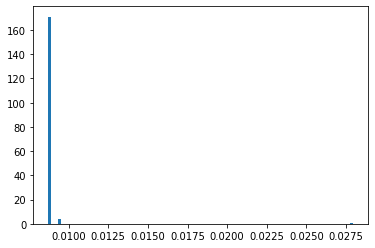

In [67]:
dataset_filelist = glob.glob("../Datasets/HTTP-Benign/*test.hdf5")

model_file = glob.glob("." + "/*.h5")[0]
print ("Model: ", model_file)
model = load_model(model_file)

for dataset in dataset_filelist:
    X_test, _ = load_dataset(dataset)
    if "benign" in dataset:
        # here we test the model on the test set of benign traffic
        # Calculate the MSE loss between the original test data and the reconstructed test data
        X_decoded = model.predict(X_test, batch_size=2048)
        mse_loss = mean_squared_error(np.squeeze(X_test), np.squeeze(X_decoded))

        print("MSE loss on test data:", mse_loss)
        n, bins, patches = plt.hist(mse_loss,bins=100)
        plt.show()

In [68]:
# set a threshold based on the mse distribution that you see in the plot
THRESHOLD=0.01

## Test with malicious traffic
Here you extract the malicious traffic from a dataset and check the distribution of the mean squared error. This is possible only because we already have some malicious data. In real-world applications, realistic malicious data might not be available for testing.

Model:  ./autoencoder-mlp.h5


2023-02-03 14:27:56.920393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


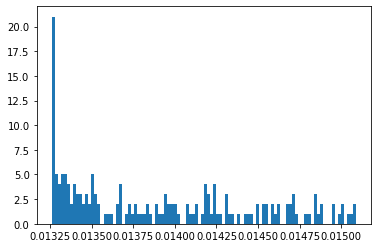

In [69]:
dataset_filelist = glob.glob("../Datasets/SYN2020/*test.hdf5")

model_file = glob.glob("." + "/*.h5")[0]
print ("Model: ", model_file)
model = load_model(model_file)

for dataset in dataset_filelist:
    X_test, Y_test = load_dataset(dataset)
    X_test_malicious = []
    for i in range(X_test.shape[0]):
        if Y_test[i] == 1:
            X_test_malicious.append(X_test[i])
    X_test = np.array(X_test_malicious)
    X_decoded = model.predict(X_test, batch_size=2048)
    mse_loss = mean_squared_error(np.squeeze(X_test), np.squeeze(X_decoded))

    n, bins, patches = plt.hist(mse_loss, bins=100)
    plt.show()

## Test the threshold
Now we evaluate the performance of our autoencoder by using the anomaly threshold that we set by looking at the mse distribution on the benign traffic. You can play with the threshold value and see how the accuracy scores are affected.

In [70]:
for dataset in dataset_filelist:
    X_test, Y_test = load_dataset(dataset)
    X_decoded = model.predict(X_test, batch_size=2048)
    mse_loss = mean_squared_error(np.squeeze(X_test), np.squeeze(X_decoded))
    Y_pred = np.squeeze(mse_loss > THRESHOLD)

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, labels=[0, 1]).ravel()
    row = {'Samples': Y_test.shape[0], 'FPR': fp / (fp+tn), 'TNR': tn / (fp+tn), 'FNR': fn / (fn+tp), 'TPR': tp / (tp+fn), 'Model': model.name}
    print(row)

{'Samples': 352, 'FPR': 0.12921348314606743, 'TNR': 0.8707865168539326, 'FNR': 0.0, 'TPR': 1.0, 'Model': 'autoencoder-mlp'}
